In [3]:
from datetime import datetime

datetime.now().strftime("%Y-%m-%d %H:%M")

'2025-12-21 16:14'


latest findings from '2025-12-21 16:14'

evaluating bars to return. 
there is a high percentage of fvg bars that return back. maybe its a rule that small fvg eventually return. 
need to test for higher fvg. and their return bars is also quite low. well idk, mean is 100 which is 100*5 Min = 500 Mins, which is more than 8 hours. 
i have a theory that most of the fvg return within the business hour but yeah whatever. 

need to check the current regime 



i will subset the data to first 2.5 hours until 12 NY time to have narrow focus. 
i also wanna see the price context



# FVG

so today i tried doing the fvg thing and i was able computing when and fvg happened and when it returned. now its my task to check those events. and also see how i can group them in different regimes or something like that. 

GPT Link for continuation of the conversation:
https://chatgpt.com/share/6945b36b-b5c0-8004-a7c9-017617702071


The Idea here is finding out what FVGs may influence or not. So could they tell a reaction for something. 
Since edges seem to flatten out over time, i think its called alphadecay, it make sense looking for edge for recent data over time constantly. 
i could have systems in place that do the analyses. i mean yeah 

## what i already have 

event df with when fvgs happen. also computed time if it returned and if yes when. 

now i need 

- impulse_strength
- direction_purity
- distance_to_vwap
- session_label

# Preparation, Data Generation
## Reading the data

in this section i also compute the previous 2 candles for that row and with vectorized computing check for FVGs

I end up with a events dataset, that contains all FVGs. it is later up to me to decide which further constraints i wanna use for my analyses. Initially selection for US Open and a certain minimum GapSize comes to mind. Then Group them by GapSize to see their group individual behavior. Also check for further Grouping like consistent candle move vs mixed candle pattern or context information like where is it relative to previous day metrics like ohlcv. 

other ideas: high volume vs low volume times (outside US Open)


In [4]:
import pandas as pd
import numpy as np

# Reading the data 
df = pd.read_csv("/Users/ducjeremyvu/alpha/price_data/US500_Minute5_20251219_1816.csv")

# Convert to Datetime 
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").reset_index(drop=True)

# in another same size vectors, create shifted 
# Bar A (i-2) and Bar C (i)
A_high = df["High"].shift(2)
A_low  = df["Low"].shift(2)
B_open = df["Open"].shift(1)
B_close = df["Close"].shift(1)
C_low  = df["Low"]
C_high = df["High"]

# FVG conditions
bull = C_low > A_high
bear = C_high < A_low

# Build event table
events = pd.DataFrame({
    "Time": df["Time"],
    "Lower": np.where(bull, A_high, np.where(bear, C_high, np.nan)),
    "Upper": np.where(bull, C_low,  np.where(bear, A_low,  np.nan)),
    "B_size": (B_close - B_open).abs(),
})

# Direction as categorical (pandas-native)
events["Direction"] = None
events.loc[bull, "Direction"] = "BULL"
events.loc[bear, "Direction"] = "BEAR"

# Keep only real FVGs
events = events.dropna(subset=["Direction"]).copy()

# Gap size
events["GapSize"] = events["Upper"] - events["Lower"]

events.head(10)

,Time,Lower,Upper,B_size,Direction,GapSize
6,2025-09-10 14:30:00,6552.3,6554.8,5.2,BEAR,2.5
7,2025-09-10 14:35:00,6551.0,6551.3,2.7,BEAR,0.3
16,2025-09-10 15:20:00,6538.8,6542.0,5.3,BEAR,3.2
20,2025-09-10 15:40:00,6540.8,6541.5,5.2,BULL,0.7
21,2025-09-10 15:45:00,6543.3,6544.0,2.7,BULL,0.7
22,2025-09-10 15:50:00,6545.5,6546.3,0.7,BULL,0.8
24,2025-09-10 16:00:00,6545.5,6546.3,3.0,BEAR,0.8
28,2025-09-10 16:20:00,6542.8,6543.3,1.5,BEAR,0.5
29,2025-09-10 16:25:00,6541.3,6542.3,1.7,BEAR,1.0
32,2025-09-10 16:40:00,6537.0,6537.3,2.2,BEAR,0.3


In [5]:
print(f"Time Min: {df["Time"].min()}, Time Max: {df["Time"].max()}")


Time Min: 2025-09-10 14:00:00, Time Max: 2025-12-19 18:15:00


### Testing of FVG Logic

In [6]:
# Gap size must always be positive
assert (events["GapSize"] > 0).all()

# Direction should only be BULL or BEAR
assert set(events["Direction"].unique()) <= {"BULL", "BEAR"}

## FVG Logic 

In [7]:
returns = []
bars_to_return = []

for idx, row in events.iterrows():
    i = row.name  # index in df
    lower = row["Lower"]
    upper = row["Upper"]

    future = df.iloc[i+1:]

    touched = future[
        (future["Low"] <= upper) &
        (future["High"] >= lower)
    ]

    if len(touched) == 0:
        returns.append(False)
        bars_to_return.append(np.nan)
    else:
        returns.append(True)
        bars_to_return.append(touched.index[0] - i)

In [8]:
events["Returned"] = returns
events["BarsToReturn"] = bars_to_return

### Tz Conversion for US Open and Filtering

In [9]:
# Convert Time to UTC and create NY time column
def add_timezones(df, time_col="Time"):
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col], utc=True)
    df["Time_NY"] = df[time_col].dt.tz_convert("America/New_York")
    return df

events = add_timezones(events)

events

,Time,Lower,Upper,B_size,Direction,GapSize,Returned,BarsToReturn,Time_NY
6,2025-09-10 14:30:00+00:00,6552.3,6554.8,5.2,BEAR,2.5,True,250.0,2025-09-10 10:30:00-04:00
7,2025-09-10 14:35:00+00:00,6551.0,6551.3,2.7,BEAR,0.3,True,1.0,2025-09-10 10:35:00-04:00
16,2025-09-10 15:20:00+00:00,6538.8,6542.0,5.3,BEAR,3.2,True,1.0,2025-09-10 11:20:00-04:00
20,2025-09-10 15:40:00+00:00,6540.8,6541.5,5.2,BULL,0.7,True,8.0,2025-09-10 11:40:00-04:00
21,2025-09-10 15:45:00+00:00,6543.3,6544.0,2.7,BULL,0.7,True,3.0,2025-09-10 11:45:00-04:00
...,...,...,...,...,...,...,...,...,...
19536,2025-12-19 15:45:00+00:00,6822.0,6823.3,8.5,BEAR,1.3,True,3.0,2025-12-19 10:45:00-05:00
19540,2025-12-19 16:05:00+00:00,6820.0,6820.5,5.0,BULL,0.5,False,NaN,2025-12-19 11:05:00-05:00
19541,2025-12-19 16:10:00+00:00,6822.5,6823.0,3.5,BULL,0.5,True,1.0,2025-12-19 11:10:00-05:00
19545,2025-12-19 16:30:00+00:00,6828.5,6829.3,3.7,BULL,0.8,True,1.0,2025-12-19 11:30:00-05:00


In [10]:
# Filtering data for US Business Hours
## might adjust the data for first 2 Hours of US Business Hours
from datetime import time
events_us_business_hours = events[(events["Time_NY"].dt.time >= time(9,30)) & (events["Time_NY"].dt.time < time(16))]
events_us_business_hours


,Time,Lower,Upper,B_size,Direction,GapSize,Returned,BarsToReturn,Time_NY
6,2025-09-10 14:30:00+00:00,6552.3,6554.8,5.2,BEAR,2.5,True,250.0,2025-09-10 10:30:00-04:00
7,2025-09-10 14:35:00+00:00,6551.0,6551.3,2.7,BEAR,0.3,True,1.0,2025-09-10 10:35:00-04:00
16,2025-09-10 15:20:00+00:00,6538.8,6542.0,5.3,BEAR,3.2,True,1.0,2025-09-10 11:20:00-04:00
20,2025-09-10 15:40:00+00:00,6540.8,6541.5,5.2,BULL,0.7,True,8.0,2025-09-10 11:40:00-04:00
21,2025-09-10 15:45:00+00:00,6543.3,6544.0,2.7,BULL,0.7,True,3.0,2025-09-10 11:45:00-04:00
...,...,...,...,...,...,...,...,...,...
19536,2025-12-19 15:45:00+00:00,6822.0,6823.3,8.5,BEAR,1.3,True,3.0,2025-12-19 10:45:00-05:00
19540,2025-12-19 16:05:00+00:00,6820.0,6820.5,5.0,BULL,0.5,False,NaN,2025-12-19 11:05:00-05:00
19541,2025-12-19 16:10:00+00:00,6822.5,6823.0,3.5,BULL,0.5,True,1.0,2025-12-19 11:10:00-05:00
19545,2025-12-19 16:30:00+00:00,6828.5,6829.3,3.7,BULL,0.8,True,1.0,2025-12-19 11:30:00-05:00


In [ ]:
events_us_business_hours["BarsToReturn"].dropna()

np.float64(100.76513911620295)

In [11]:
# Testing that data is within hour boundaries

assert set(events_us_business_hours["Time_NY"].dt.hour.unique()) <= {9, 10, 11, 12, 13, 14, 15}


### Metric: count fo Gap Sizes sorted by counts

In [12]:
gap_size_count = events_us_business_hours["GapSize"].value_counts(dropna=False).reset_index()
gap_size_count.head(10)

,GapSize,count
0,0.5,108
1,1.0,78
2,1.5,68
3,0.2,61
4,0.7,54
5,2.0,52
6,0.3,51
7,0.8,50
8,1.3,34
9,1.2,32


## Summary Plots
plotting the data now and check if there is anythign interesting 

### Distribution

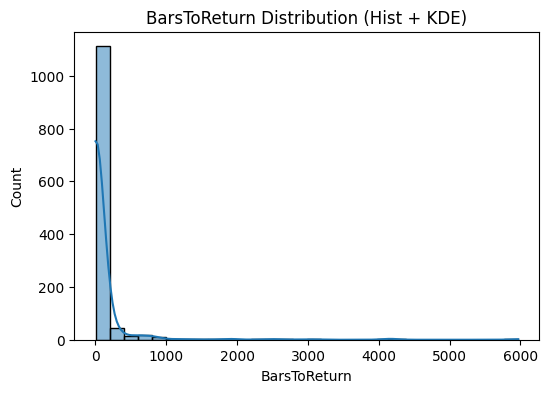

In [34]:
# 1) Distribution: histogram + KDE
import seaborn as sns
import matplotlib.pyplot as plt

col = "BarsToReturn"
# gaps = events_us_business_hours["GapSize"].dropna()
gaps = events_us_business_hours[col].dropna()

plt.figure(figsize=(6, 4))
sns.histplot(gaps, bins=30, kde=True)
plt.title(f"{col} Distribution (Hist + KDE)")
plt.xlabel(f"{col}")
plt.ylabel("Count")
plt.show()

this only tells me that tha gap size count decreases the greater the gap size but its kinda obvious but ok good to have it statistically backed. 


### Log Distribution

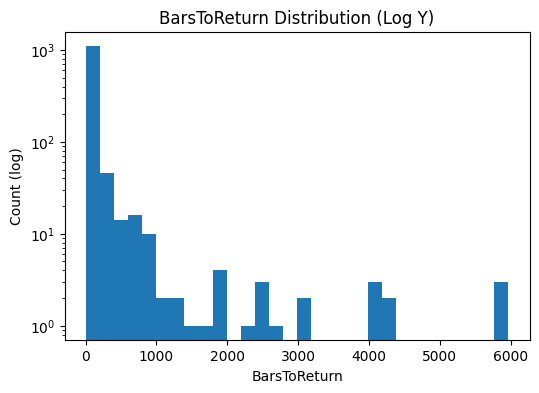

In [33]:
# 2) Distribution on log scale (useful if right-skewed)
plt.figure(figsize=(6, 4))
plt.hist(gaps, bins=30)
plt.yscale("log")
plt.title(f"{col} Distribution (Log Y)")
plt.xlabel(f"{col}")
plt.ylabel("Count (log)")
plt.show()


### Boxplot

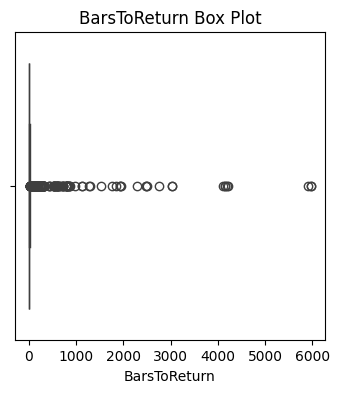

In [32]:
# 3) Outliers: box plot
plt.figure(figsize=(4, 4))
sns.boxplot(x=gaps)
plt.title(f"{col} Box Plot")
plt.xlabel(f"{col}")
plt.show()


### Violin Plot

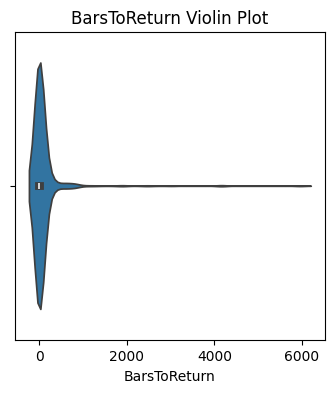

In [31]:
# 4) Outliers: violin plot
plt.figure(figsize=(4, 4))
sns.violinplot(x=gaps)
plt.title(f"{col} Violin Plot")
plt.xlabel(f"{col}")
plt.show()


### Rolling Median

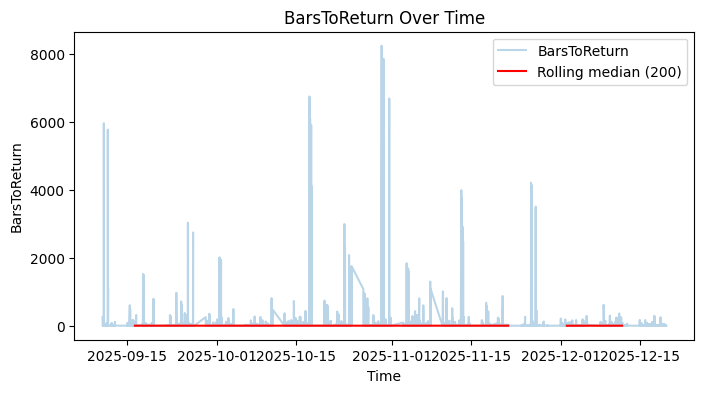

In [30]:
# 5) Over time: rolling median
events_sorted = events.sort_values("Time")
events_sorted[f"roll_med_{col}"] = events_sorted[col].rolling(200).median()

plt.figure(figsize=(8, 4))
plt.plot(events_sorted["Time"], events_sorted[col], alpha=0.3, label=col)
plt.plot(events_sorted["Time"], events_sorted[f"roll_med_{col}"], color="red", label="Rolling median (200)")
plt.title(f"{col} Over Time")
plt.xlabel("Time")
plt.ylabel(col)
plt.legend()
plt.show()


### Scatter GapSize vs BSize

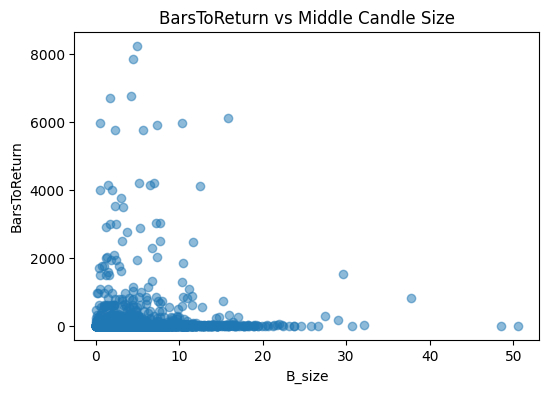

In [29]:
# 6) Relationship: scatter vs B_size
plt.figure(figsize=(6, 4))
plt.scatter(events["B_size"], events[col], alpha=0.5)
plt.title(f"{col} vs Middle Candle Size")
plt.xlabel("B_size")
plt.ylabel(col)
plt.show()


# Individual Day inspection

In [31]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True

35
40
True
Time            2025-09-10 16:55:00+00:00
Lower                              6536.8
Upper                              6539.0
B_size                                4.0
Direction                            BULL
GapSize                               2.2
Returned                             True
BarsToReturn                          5.0
Time_NY         2025-09-10 12:55:00-04:00
Name: 35, dtype: object


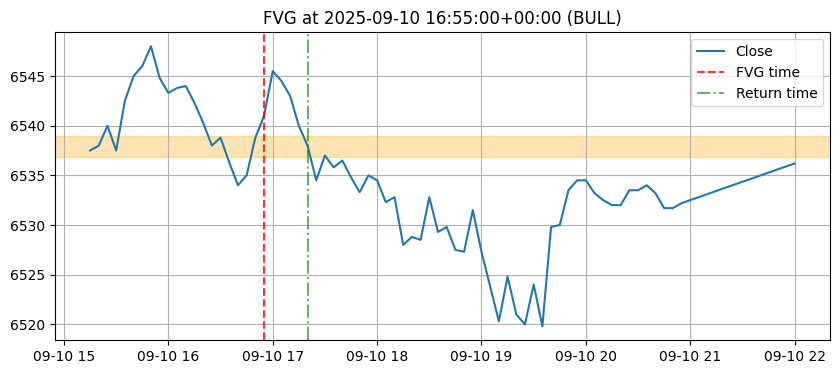

In [32]:
from datetime import time 
i = events.index[10]  # pick one FVG
row = events.loc[i]

start = max(i - 20, 0)
end = i + 50

i_return = int(i + row["BarsToReturn"])
print(i)
print(i_return)
return_inside_window = i_return < end 
print(return_inside_window)

slice_df = df.iloc[start:end]

plt.plot(slice_df["Time"], slice_df["Close"], label="Close")
plt.axvline(row["Time"], color="red", linestyle="--", alpha=0.8, label="FVG time")
if return_inside_window:
    plt.axvline(df.iloc[i_return]["Time"], color="green", linestyle="-.", alpha=0.6, label="Return time")
plt.axhspan(row["Lower"], row["Upper"], color="orange", alpha=0.3)

plt.title(f"FVG at {row['Time']} ({row['Direction']})")
plt.legend()
print(row)
plt.show()

### Possible Widget Idea
below is code for widget where you can toggle with keyboard buttons but it seems that it renders them all first so maybe try to limit the number of events per call 

maybe: 

pages: 
```
p = input(1, 2, ... )
x_base = 10
x = x_base + p
page_start = x - 10
page_end = x
```

In [33]:
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from IPython.display import display, clear_output

# def plot_fvg(event_pos):
#     # --- pick event ---
#     i = events.index[event_pos]
#     row = events.loc[i]

#     start = max(i - 20, 0)
#     end = i + 50

#     # handle NaNs defensively
#     if pd.isna(row["BarsToReturn"]):
#         i_return = None
#         return_inside_window = False
#     else:
#         i_return = int(i + row["BarsToReturn"])
#         return_inside_window = i_return < end

#     slice_df = df.iloc[start:end]

#     with out:
#         clear_output(wait=True)
#         plt.figure(figsize=(10, 4))
#         plt.plot(slice_df["Time"], slice_df["Close"], label="Close")

#         plt.axvline(row["Time"], color="red", linestyle="--", alpha=0.8, label="FVG time")

#         if return_inside_window:
#             plt.axvline(
#                 df.iloc[i_return]["Time"],
#                 color="green",
#                 linestyle="-.",
#                 alpha=0.6,
#                 label="Return time",
#             )

#         plt.axhspan(row["Lower"], row["Upper"], color="orange", alpha=0.3)
#         plt.title(f"FVG #{event_pos} | {row['Direction']} | BarsToReturn={row['BarsToReturn']}")
#         plt.legend()
#         plt.show()

#         display(row)  # nice touch: inspect the event live


# # --- widgets ---
# slider = widgets.IntSlider(
#     value=5,
#     min=0,
#     max=len(events) - 1,
#     step=1,
#     description="Event",
#     continuous_update=False
# )

# out = widgets.Output()

# slider.observe(lambda ch: plot_fvg(ch["new"]), names="value")

# display(slider, out)
# plot_fvg(slider.value)


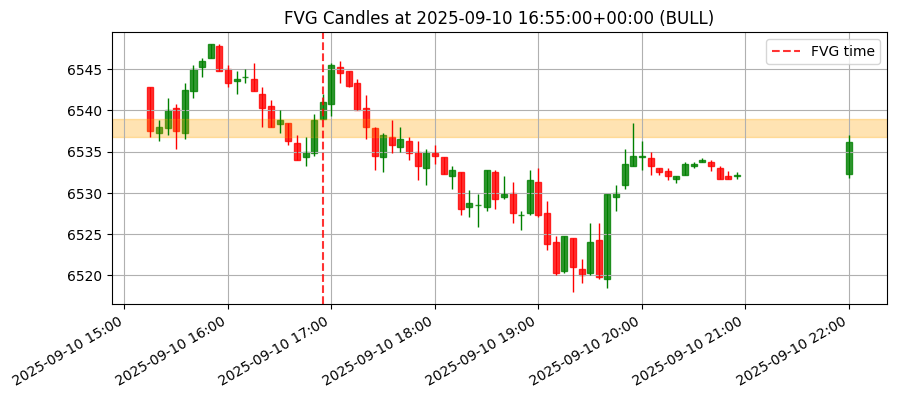

In [34]:
# Candlestick view of the same FVG window
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

slice_df = df.iloc[start:end].copy()
time_nums = mdates.date2num(slice_df["Time"])

fig, ax = plt.subplots(figsize=(10, 4))
if len(time_nums) > 1:
    candle_width = (time_nums[1] - time_nums[0]) * 0.7
else:
    candle_width = 0.0005

for t, (_, r) in zip(time_nums, slice_df.iterrows()):
    color = "green" if r["Close"] >= r["Open"] else "red"
    ax.vlines(r["Time"], r["Low"], r["High"], color=color, linewidth=1)
    lower = min(r["Open"], r["Close"])
    height = abs(r["Close"] - r["Open"])
    rect = Rectangle((t - candle_width / 2, lower), candle_width, max(height, 1e-9),
                     facecolor=color, edgecolor=color, alpha=0.8)
    ax.add_patch(rect)

ax.axhspan(row["Lower"], row["Upper"], color="orange", alpha=0.3)
ax.axvline(row["Time"], color="red", linestyle="--", alpha=0.8, label="FVG time")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
fig.autofmt_xdate()
ax.set_title(f"FVG Candles at {row['Time']} ({row['Direction']})")
ax.legend()
plt.show()


## Unrelated Analyses and Ideas

In [35]:
events.head()



,Time,Lower,Upper,B_size,Direction,GapSize,Returned,BarsToReturn,Time_NY
6,2025-09-10 14:30:00+00:00,6552.3,6554.8,5.2,BEAR,2.5,True,250.0,2025-09-10 10:30:00-04:00
7,2025-09-10 14:35:00+00:00,6551.0,6551.3,2.7,BEAR,0.3,True,1.0,2025-09-10 10:35:00-04:00
16,2025-09-10 15:20:00+00:00,6538.8,6542.0,5.3,BEAR,3.2,True,1.0,2025-09-10 11:20:00-04:00
20,2025-09-10 15:40:00+00:00,6540.8,6541.5,5.2,BULL,0.7,True,8.0,2025-09-10 11:40:00-04:00
21,2025-09-10 15:45:00+00:00,6543.3,6544.0,2.7,BULL,0.7,True,3.0,2025-09-10 11:45:00-04:00


In [36]:
events[events["GapSize"] > 20]

,Time,Lower,Upper,B_size,Direction,GapSize,Returned,BarsToReturn,Time_NY
5968,2025-10-10 15:00:00+00:00,6713.9,6749.3,37.8,BEAR,35.4,True,815.0,2025-10-10 11:00:00-04:00
6027,2025-10-10 19:55:00+00:00,6555.6,6577.6,20.7,BEAR,22.0,True,1.0,2025-10-10 15:55:00-04:00
6039,2025-10-12 22:00:00+00:00,6557.3,6612.8,48.5,BULL,55.5,True,1.0,2025-10-12 18:00:00-04:00
6040,2025-10-12 22:05:00+00:00,6556.3,6601.6,4.3,BULL,45.3,True,367.0,2025-10-12 18:05:00-04:00
8797,2025-10-26 22:00:00+00:00,6793.5,6835.9,0.5,BULL,42.4,True,1084.0,2025-10-26 18:00:00-04:00
8798,2025-10-26 22:05:00+00:00,6793.0,6841.7,3.2,BULL,48.7,True,1.0,2025-10-26 18:05:00-04:00
9597,2025-10-29 18:40:00+00:00,6875.7,6903.8,50.6,BEAR,28.1,True,2.0,2025-10-29 14:40:00-04:00
11555,2025-11-09 23:00:00+00:00,6741.0,6764.6,1.8,BULL,23.6,True,1.0,2025-11-09 18:00:00-05:00
11556,2025-11-09 23:05:00+00:00,6742.5,6763.7,5.7,BULL,21.2,True,1.0,2025-11-09 18:05:00-05:00
13434,2025-11-18 17:40:00+00:00,6608.2,6630.0,22.0,BULL,21.8,True,37.0,2025-11-18 12:40:00-05:00


In [37]:
from scipy.stats import zscore

z = zscore(events_us_business_hours["GapSize"])
events_no_outliers = events_us_business_hours[(z > -3) & (z < 3)]


In [38]:
events_no_outliers

,Time,Lower,Upper,B_size,Direction,GapSize,Returned,BarsToReturn,Time_NY
6,2025-09-10 14:30:00+00:00,6552.3,6554.8,5.2,BEAR,2.5,True,250.0,2025-09-10 10:30:00-04:00
7,2025-09-10 14:35:00+00:00,6551.0,6551.3,2.7,BEAR,0.3,True,1.0,2025-09-10 10:35:00-04:00
16,2025-09-10 15:20:00+00:00,6538.8,6542.0,5.3,BEAR,3.2,True,1.0,2025-09-10 11:20:00-04:00
20,2025-09-10 15:40:00+00:00,6540.8,6541.5,5.2,BULL,0.7,True,8.0,2025-09-10 11:40:00-04:00
21,2025-09-10 15:45:00+00:00,6543.3,6544.0,2.7,BULL,0.7,True,3.0,2025-09-10 11:45:00-04:00
...,...,...,...,...,...,...,...,...,...
19536,2025-12-19 15:45:00+00:00,6822.0,6823.3,8.5,BEAR,1.3,True,3.0,2025-12-19 10:45:00-05:00
19540,2025-12-19 16:05:00+00:00,6820.0,6820.5,5.0,BULL,0.5,False,NaN,2025-12-19 11:05:00-05:00
19541,2025-12-19 16:10:00+00:00,6822.5,6823.0,3.5,BULL,0.5,True,1.0,2025-12-19 11:10:00-05:00
19545,2025-12-19 16:30:00+00:00,6828.5,6829.3,3.7,BULL,0.8,True,1.0,2025-12-19 11:30:00-05:00


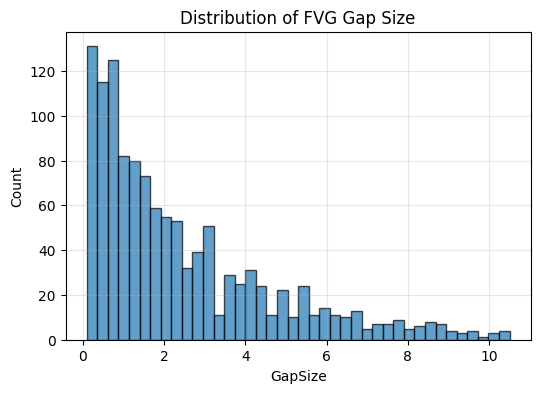

In [39]:
# Histogram of FVG gap sizes
plt.figure(figsize=(6, 4))
plt.hist(events_no_outliers["GapSize"], bins=40, alpha=0.7, edgecolor="black")
plt.xlabel("GapSize")
plt.ylabel("Count")
plt.title("Distribution of FVG Gap Size")
plt.grid(True, alpha=0.3)
plt.show()


idea 

create an object, a class that contains preprocessing functions, like changing timezones etc. not sure if necessary but would be cool 

# Archived Findings


# Findings from above 21 Dec 2025 13:00 
## having observered all us business hour data

- smaller FVG obviously account for the most occurences 
- there exist some higher outliers 
- majority accumulates around a small range from 0 to 1.5
- there is some indication that B candle size could inlfuence fvg but not really 

next thing to do: 
further checks, maybe partitioning, maybe check how many returned in general. 
check the outlier values, what their behavior is.